In [77]:
import pandas as pd
import numpy as np
from numpy import absolute
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import matplotlib.path as mpath

In [91]:
def readCSVFiles():

    df01 = pd.read_csv("bellman_performance_results.csv")
    df02 = pd.read_csv("dijkstra_performance_results.csv")
    df03 = pd.read_csv("hybrid_performance_results.csv")

    return df01, df02, df03

def combineAlgorithmsToFile(df01, df02, df03):
    df01['AlgoBellman'] = 1
    df01['AlgoDijkstra'] = 0
    df01['AlgoHybrid'] = 0
    df02['AlgoBellman'] = 0
    df02['AlgoDijkstra'] = 1
    df02['AlgoHybrid'] = 0
    df03['AlgoBellman'] = 0
    df03['AlgoDijkstra'] = 0
    df03['AlgoHybrid'] = 1
    frames = [df01, df02, df03]
    concat = pd.concat(frames)
    df1 = concat
    
    return df1


def executionTimeToSpeedup(df):
    
    algorithms = ['AlgoBellman', 'AlgoDijkstra', 'AlgoHybrid']
    vertexNums = [524288, 1048576, 2097152, 4194304, 8388608, 16777216]
    df['speedup'] = 1.0

    for al in algorithms:
        for v in vertexNums:
            base = df.loc[(df[al] == 1) & (df['vertexNum'] == v) & (df['sOriginalDistance'] == 1), 'executionTime']
            df.loc[(df[al] == 1) & (df['vertexNum'] == v), 'speedup'] = base.values/((df.loc[(df[al] == 1) & (df['vertexNum'] == v), 'executionTime']).astype(float))

    return df
    

def find_approximation(approximation_list, approximation_names):
  
    index = 0
    count = 0
    appr = []
    for i in approximation_list:
        if i == 1:
            count+=1
            appr.append(approximation_names[index])
        index+=1
        
    return count, appr
            
            
def calculate_speedup(df, nv_list, algorithm_name, approximation_list, approximation_names):
    
    count, appr = find_approximation(approximation_list, approximation_names)
    speedup_list = []
    
    for nv in nv_list:

        original_speed = (df.loc[(df['vertexNum'] == nv) & (df[algorithm_name] == 1) &
                         (df['sOriginalDistance'] == 1), 'executionTime'])
        
        group_by_nv = df.loc[(df['vertexNum'] == nv) & (df[algorithm_name] == 1)]
        
        for index,row in group_by_nv.iterrows():
            
            if row['sMinEdgetoProcess'] == approximation_list[0] and row['sPartialGraphProcess'] == approximation_list[1] and row['sReduceExecution'] == approximation_list[2] and row['sMaxEdgetoProcess'] == approximation_list[3]:
        
                if row['executionTime'] == 0:
                    speedup = (original_speed/1).to_numpy()[0]
                else:
                    speedup = (original_speed/row['executionTime']).to_numpy()[0]
            
                if count == 1:
                    speedup_list.append([speedup, row['Error'], row[appr[0]]])
                elif count == 2:
                    speedup_list.append([speedup, row['Error'], row[appr[0]], row[appr[1]]])
                elif count == 3:
                    speedup_list.append([speedup, row['Error'], row[appr[0]], row[appr[1]], row[appr[2]]])
                elif count == 4:
                    speedup_list.append([speedup, row['Error'], row[appr[0]], row[appr[1]], row[appr[2]], row[appr[3]]])
                
                
    return speedup_list


def draw_BFDJ(arr1_b, arr2_b, arr1_d, arr2_d, arr1_h, arr2_h, x_label, y_label):
    
    #star = mpath.Path.unit_regular_star(6)
    #rectangle = mpath.Path.unit_rectangle()
    asterisk = mpath.Path.unit_regular_asterisk(6)
    circle = mpath.Path.unit_circle()
    rectangle = mpath.Path.unit_rectangle()

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(arr2_b, arr1_b, color='red', label='bellman-ford', marker=asterisk, markersize=7)
    ax.plot(arr2_d, arr1_d, color='blue', label='dijkstra', marker=circle, markersize=4)
    ax.plot(arr2_h, arr1_h, color='green', label='hybrid', marker=rectangle, markersize=4)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    plt.legend()
    plt.show()
    
    

def prepare_draw(s, error, approximation):

    for c in range(6):

        arr1_b, arr2_b, arr1_d, arr2_d, arr1_h, arr2_h = []

        count = 1
        for i in iterationNum_list_b[c]:
            arr1_b.append(i[s])
            arr2_b.append(count)
            count+=1

        count = 1
        for i in iterationNum_list_d[c]:
            arr1_d.append(i[s])
            arr2_d.append(count)
            count+=1
            
        count = 1
        for i in iterationNum_list_h[c]:
            arr1_h.append(i[s])
            arr2_h.append(count)
            count+=1

            
        draw_BFDJ(arr1_b, arr2_b, arr1_d, arr2_d, arr1_h, arr2_h, "iteration number", soe)


In [92]:
df01, df02, df03 = readCSVFiles()
df1 = combineAlgorithmsToFile(df01, df02, df03)
df1 = executionTimeToSpeedup(df1)

In [166]:
'''
signal order:

signals = ['sMinEdgetoProcess', 'sMaxEdgetoProcess', 'sPartialGraphProcess', 'sReduceExecution']
'''

def meanSummary(df, algorithm, signals, approximation_technique):
    
    test = df.loc[(df[algorithm] == 1) & 
              (df['sMinEdgetoProcess'] == signals[0]) & (df['sMaxEdgetoProcess'] == signals[1]) & 
              (df['sPartialGraphProcess'] == signals[2]) & (df['sReduceExecution'] == signals[3])]

    speedup, error = [], []
    approximation = test.loc[test['vertexNum'] == 16777216, approximation_technique].to_numpy()

    for i in approximation:
        speedup.append(test.loc[test[approximation_technique] == i, 'speedup'].mean())
        error.append(test.loc[test[approximation_technique] == i, 'Error'].mean())


    speedup = np.array(speedup)
    error = np.array(error)
    
    return speedup, error, approximation


def rearrange_data(algorithm, approximation_technique, speedup, error, approximation):
    
    data, l = [], []
    
    for i in range(len(approximation)):
        data.append([algorithm, approximation_technique, approximation[i], speedup[i], error[i]])
                
    #data.append(l)
        
    return data
    

def draw_threeline(algorithm, approximation_technique, speedup, error, approximation, color, magic_error1, magic_error2, magic_speedup1, magic_speedup2):

    asterisk = mpath.Path.unit_regular_asterisk(6)
    circle = mpath.Path.unit_circle()
    rectangle = mpath.Path.unit_rectangle()

    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1)

    ax1.plot(approximation, speedup, color=color, label=algorithm, marker=asterisk, markersize=7)
    ax1.set_xlabel(approximation_technique)
    mn,mx = ax1.set_ylim(speedup.min()-magic_speedup1, speedup.max()+magic_speedup2)
    ax1.set_ylabel('speedup')

    ax2 = ax1.twinx()
    ax2.set_ylim(error.min()-magic_error1, error.max()+magic_error2)
    ax2.set_ylabel('inaccuracy')

    plt.show()

In [167]:
algoB = 'AlgoBellman'
algoD = 'AlgoDijkstra'
algoH = 'AlgoHybrid'
signals = [1, 0, 0, 0]
approximation_technique = 'minProcessEdge'

speedup, error, approximation = meanSummary(df1, algoB, signals, approximation_technique)
data = rearrange_data(algoB, approximation_technique, speedup, error, approximation)
df = pd.DataFrame(data, columns=['Algorithm', 'Technique', approximation_technique, 'mean-speedup', 'mean-inaccuracy'])
df

,Algorithm,Technique,minProcessEdge,mean-speedup,mean-inaccuracy
0,AlgoBellman,minProcessEdge,2,1.042730,0.12188
1,AlgoBellman,minProcessEdge,5,1.051971,0.36305
2,AlgoBellman,minProcessEdge,15,1.083955,1.12370
3,AlgoBellman,minProcessEdge,30,1.104224,1.51740
4,AlgoBellman,minProcessEdge,37,1.138913,2.25940
5,AlgoBellman,minProcessEdge,45,1.135568,2.86020
6,AlgoBellman,minProcessEdge,121,1.239223,5.70830


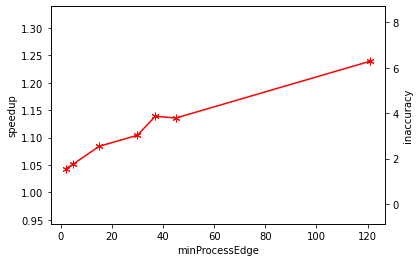

In [168]:
draw_threeline(algoB, approximation_technique, speedup, error, approximation, 'red', 1, 3, 0.1, 0.1)

In [169]:
speedup, error, approximation = meanSummary(df1, algoD, signals, approximation_technique)
data = rearrange_data(algoD, approximation_technique, speedup, error, approximation)
df = pd.DataFrame(data, columns=['Algorithm', 'Technique', approximation_technique, 'mean-speedup', 'mean-inaccuracy'])
df

,Algorithm,Technique,minProcessEdge,mean-speedup,mean-inaccuracy
0,AlgoDijkstra,minProcessEdge,2,1.072494,0.12188
1,AlgoDijkstra,minProcessEdge,5,1.068682,0.36305
2,AlgoDijkstra,minProcessEdge,15,1.133808,1.12370
3,AlgoDijkstra,minProcessEdge,30,1.128571,1.51740
4,AlgoDijkstra,minProcessEdge,37,1.148064,2.25940
5,AlgoDijkstra,minProcessEdge,45,1.150727,2.86020
6,AlgoDijkstra,minProcessEdge,121,1.242731,5.70830


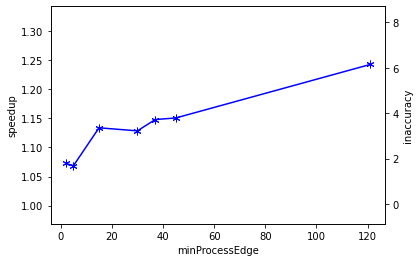

In [170]:
draw_threeline(algoD, approximation_technique, speedup, error, approximation, 'blue', 1, 3, 0.1, 0.1)

In [171]:
speedup, error, approximation = meanSummary(df1, algoH, signals, approximation_technique)
data = rearrange_data(algoH, approximation_technique, speedup, error, approximation)
df = pd.DataFrame(data, columns=['Algorithm', 'Technique', approximation_technique, 'mean-speedup', 'mean-inaccuracy'])
df

,Algorithm,Technique,minProcessEdge,mean-speedup,mean-inaccuracy
0,AlgoHybrid,minProcessEdge,2,1.041441,0.12188
1,AlgoHybrid,minProcessEdge,5,1.052256,0.36305
2,AlgoHybrid,minProcessEdge,15,1.094625,1.12370
3,AlgoHybrid,minProcessEdge,30,1.106991,1.51740
4,AlgoHybrid,minProcessEdge,37,1.112926,2.25940
5,AlgoHybrid,minProcessEdge,45,1.117454,2.86020
6,AlgoHybrid,minProcessEdge,121,1.185776,5.70830


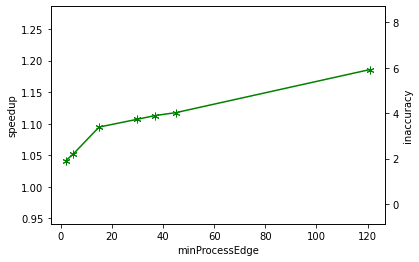

In [172]:
draw_threeline(algoH, approximation_technique, speedup, error, approximation, 'green', 1, 3, 0.1, 0.1)

In [173]:
signals = [0, 1, 0, 0]
approximation_technique = 'maxProcessEdge'

speedup, error, approximation = meanSummary(df1, algoB, signals, approximation_technique)
data = rearrange_data(algoB, approximation_technique, speedup, error, approximation)
df = pd.DataFrame(data, columns=['Algorithm', 'Technique', approximation_technique, 'mean-speedup', 'mean-inaccuracy'])
df

,Algorithm,Technique,maxProcessEdge,mean-speedup,mean-inaccuracy
0,AlgoBellman,maxProcessEdge,91587,0.991299,0.0142
1,AlgoBellman,maxProcessEdge,1196,1.169100,13.3084
2,AlgoBellman,maxProcessEdge,1152,1.282426,17.6803
3,AlgoBellman,maxProcessEdge,1112,1.280202,22.8507
4,AlgoBellman,maxProcessEdge,392,1.267463,26.0612


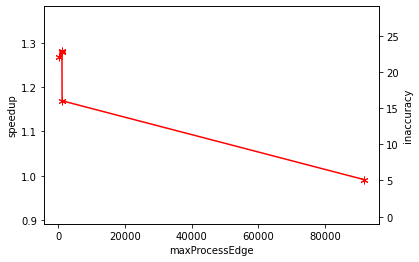

In [174]:
draw_threeline(algoB, approximation_technique, speedup, error, approximation, 'red', 1, 3, 0.1, 0.1)

In [175]:
speedup, error, approximation = meanSummary(df1, algoD, signals, approximation_technique)
data = rearrange_data(algoD, approximation_technique, speedup, error, approximation)
df = pd.DataFrame(data, columns=['Algorithm', 'Technique', approximation_technique, 'mean-speedup', 'mean-inaccuracy'])
df

,Algorithm,Technique,maxProcessEdge,mean-speedup,mean-inaccuracy
0,AlgoDijkstra,maxProcessEdge,91587,1.060157,0.0142
1,AlgoDijkstra,maxProcessEdge,1196,1.411955,13.3084
2,AlgoDijkstra,maxProcessEdge,1152,1.498526,17.6803
3,AlgoDijkstra,maxProcessEdge,1112,1.546393,22.8507
4,AlgoDijkstra,maxProcessEdge,392,1.595349,26.0612


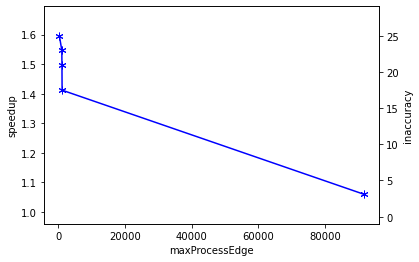

In [176]:
draw_threeline(algoD, approximation_technique, speedup, error, approximation, 'blue', 1, 3, 0.1, 0.1)

In [177]:
speedup, error, approximation = meanSummary(df1, algoH, signals, approximation_technique)
data = rearrange_data(algoH, approximation_technique, speedup, error, approximation)
df = pd.DataFrame(data, columns=['Algorithm', 'Technique', approximation_technique, 'mean-speedup', 'mean-inaccuracy'])
df

,Algorithm,Technique,maxProcessEdge,mean-speedup,mean-inaccuracy
0,AlgoHybrid,maxProcessEdge,91587,1.061553,0.0142
1,AlgoHybrid,maxProcessEdge,1196,1.349569,13.3084
2,AlgoHybrid,maxProcessEdge,1152,1.389583,17.6803
3,AlgoHybrid,maxProcessEdge,1112,1.437721,22.8507
4,AlgoHybrid,maxProcessEdge,392,1.471180,26.0612


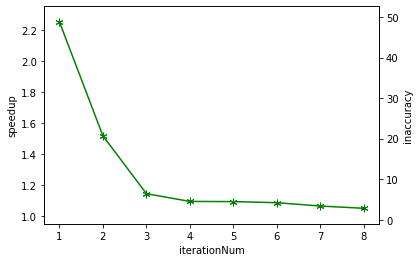

In [190]:
draw_threeline(algoH, approximation_technique, speedup, error, approximation, 'green', 1, 3, 0.1, 0.1)

In [178]:
signals = [0, 0, 1, 0]
approximation_technique = 'percentage'

speedup, error, approximation = meanSummary(df1, algoB, signals, approximation_technique)
data = rearrange_data(algoB, approximation_technique, speedup, error, approximation)
df = pd.DataFrame(data, columns=['Algorithm', 'Technique', approximation_technique, 'mean-speedup', 'mean-inaccuracy'])
df

,Algorithm,Technique,percentage,mean-speedup,mean-inaccuracy
0,AlgoBellman,percentage,0.25,1.346097,27.033833
1,AlgoBellman,percentage,0.50,1.109228,16.616083
2,AlgoBellman,percentage,0.75,1.002968,12.149700
3,AlgoBellman,percentage,0.90,0.961152,10.441317


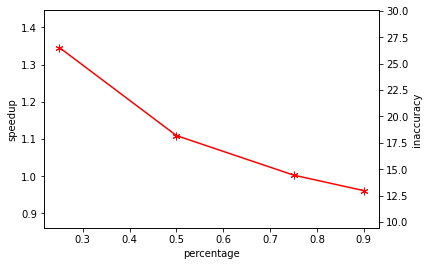

In [179]:
draw_threeline(algoB, approximation_technique, speedup, error, approximation, 'red', 1, 3, 0.1, 0.1)

In [180]:
speedup, error, approximation = meanSummary(df1, algoD, signals, approximation_technique)
data = rearrange_data(algoD, approximation_technique, speedup, error, approximation)
df = pd.DataFrame(data, columns=['Algorithm', 'Technique', approximation_technique, 'mean-speedup', 'mean-inaccuracy'])
df

,Algorithm,Technique,percentage,mean-speedup,mean-inaccuracy
0,AlgoDijkstra,percentage,0.25,0.930393,36.292183
1,AlgoDijkstra,percentage,0.50,0.775767,17.439183
2,AlgoDijkstra,percentage,0.75,0.739964,6.376033
3,AlgoDijkstra,percentage,0.90,0.737600,2.626267


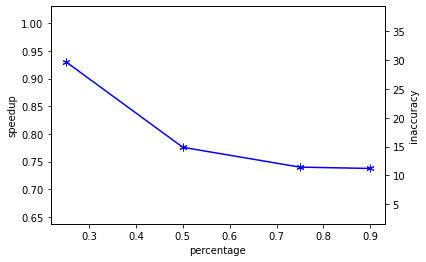

In [181]:
draw_threeline(algoD, approximation_technique, speedup, error, approximation, 'blue', 1, 3, 0.1, 0.1)

In [182]:
speedup, error, approximation = meanSummary(df1, algoH, signals, approximation_technique)
data = rearrange_data(algoH, approximation_technique, speedup, error, approximation)
df = pd.DataFrame(data, columns=['Algorithm', 'Technique', approximation_technique, 'mean-speedup', 'mean-inaccuracy'])
df

,Algorithm,Technique,percentage,mean-speedup,mean-inaccuracy
0,AlgoHybrid,percentage,0.25,0.921964,36.425650
1,AlgoHybrid,percentage,0.50,0.812265,17.526083
2,AlgoHybrid,percentage,0.75,0.777440,6.326750
3,AlgoHybrid,percentage,0.90,0.766080,2.648033


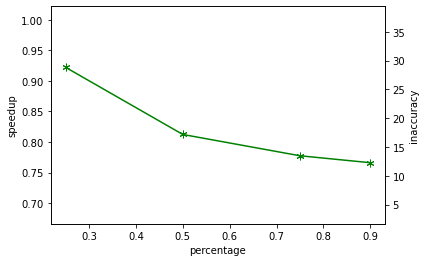

In [183]:
draw_threeline(algoH, approximation_technique, speedup, error, approximation, 'green', 1, 3, 0.1, 0.1)

In [184]:
signals = [0, 0, 0, 1]
approximation_technique = 'iterationNum'

speedup, error, approximation = meanSummary(df1, algoB, signals, approximation_technique)
data = rearrange_data(algoB, approximation_technique, speedup, error, approximation)
df = pd.DataFrame(data, columns=['Algorithm', 'Technique', approximation_technique, 'mean-speedup', 'mean-inaccuracy'])
df

,Algorithm,Technique,iterationNum,mean-speedup,mean-inaccuracy
0,AlgoBellman,iterationNum,1,2.135236,19.647533
1,AlgoBellman,iterationNum,2,1.065343,0.153600
2,AlgoBellman,iterationNum,3,1.028519,0.001850
3,AlgoBellman,iterationNum,4,1.023008,0.000033
4,AlgoBellman,iterationNum,5,1.031953,0.000000
5,AlgoBellman,iterationNum,6,1.024592,0.000000
6,AlgoBellman,iterationNum,7,1.018468,0.000000


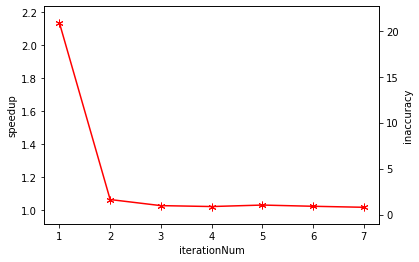

In [185]:
draw_threeline(algoB, approximation_technique, speedup, error, approximation, 'red', 1, 3, 0.1, 0.1)

In [186]:
speedup, error, approximation = meanSummary(df1, algoD, signals, approximation_technique)
data = rearrange_data(algoD, approximation_technique, speedup, error, approximation)
df = pd.DataFrame(data, columns=['Algorithm', 'Technique', approximation_technique, 'mean-speedup', 'mean-inaccuracy'])
df

,Algorithm,Technique,iterationNum,mean-speedup,mean-inaccuracy
0,AlgoDijkstra,iterationNum,1,3.576912,49.620033
1,AlgoDijkstra,iterationNum,2,1.816557,31.450717
2,AlgoDijkstra,iterationNum,3,1.224133,1.073367
3,AlgoDijkstra,iterationNum,4,1.171635,0.013600
4,AlgoDijkstra,iterationNum,5,1.154548,0.000150
5,AlgoDijkstra,iterationNum,6,1.145552,0.000000
6,AlgoDijkstra,iterationNum,7,1.104540,0.000000
7,AlgoDijkstra,iterationNum,8,1.091008,0.000000


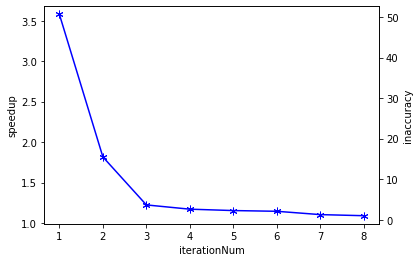

In [187]:
draw_threeline(algoD, approximation_technique, speedup, error, approximation, 'blue', 1, 3, 0.1, 0.1)

In [188]:
speedup, error, approximation = meanSummary(df1, algoH, signals, approximation_technique)
data = rearrange_data(algoH, approximation_technique, speedup, error, approximation)
df = pd.DataFrame(data, columns=['Algorithm', 'Technique', approximation_technique, 'mean-speedup', 'mean-inaccuracy'])
df

,Algorithm,Technique,iterationNum,mean-speedup,mean-inaccuracy
0,AlgoHybrid,iterationNum,1,2.253395,49.620033
1,AlgoHybrid,iterationNum,2,1.517331,31.450717
2,AlgoHybrid,iterationNum,3,1.143655,1.073367
3,AlgoHybrid,iterationNum,4,1.093579,0.013600
4,AlgoHybrid,iterationNum,5,1.092520,0.000150
5,AlgoHybrid,iterationNum,6,1.085447,0.000000
6,AlgoHybrid,iterationNum,7,1.063959,0.000000
7,AlgoHybrid,iterationNum,8,1.049092,0.000000


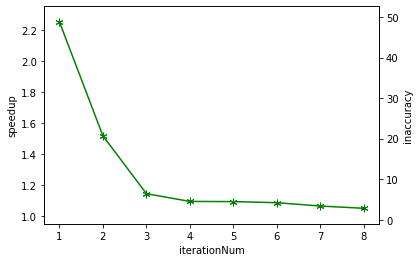

In [189]:
draw_threeline(algoH, approximation_technique, speedup, error, approximation, 'green', 1, 3, 0.1, 0.1)

In [205]:
'''
signal order:

signals = ['sMinEdgetoProcess', 'sMaxEdgetoProcess', 'sPartialGraphProcess', 'sReduceExecution']
'''

test = df1.loc[(df1[algoB] == 1) & (df1['vertexNum'] == 16777216) &
       (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
       (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'speedup']

print(test)

10548    1.006091
10549    1.045406
10550    1.083955
10551    1.104224
10552    1.138913
10553    1.160252
10554    1.239223
Name: speedup, dtype: float64


In [212]:
algoB = 'AlgoBellman'
algoD = 'AlgoDijkstra'
algoH = 'AlgoHybrid'
vn = [524288, 1048576, 2097152, 4194304, 8388608, 16777216]

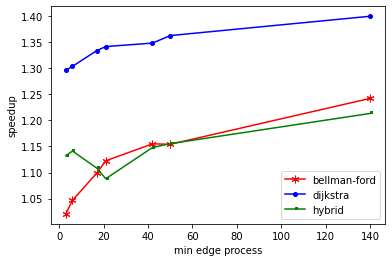

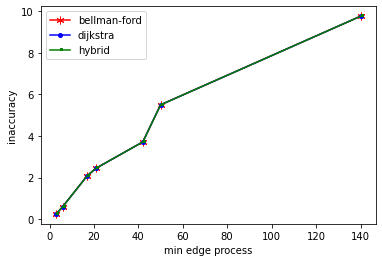

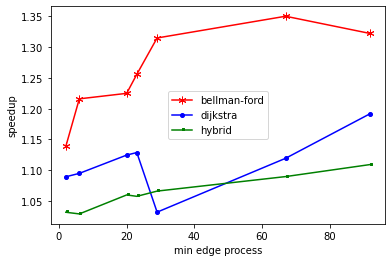

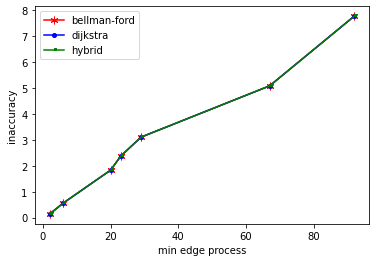

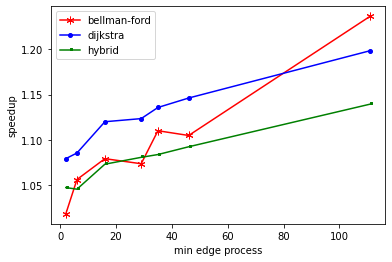

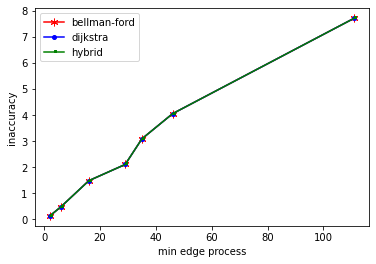

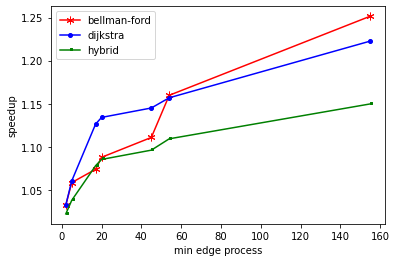

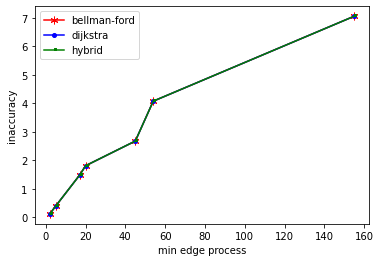

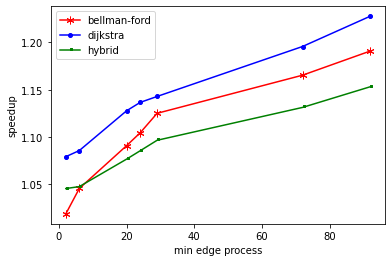

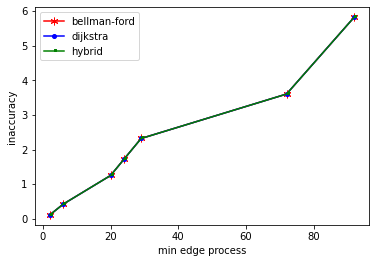

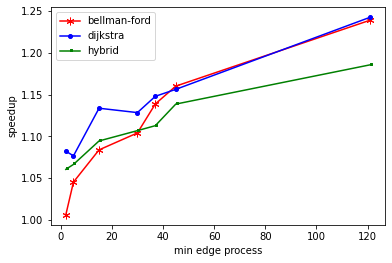

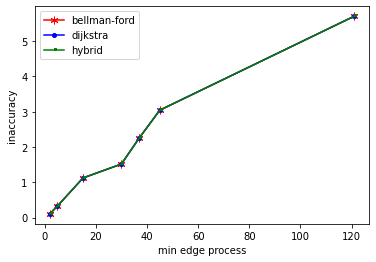

In [213]:
signals = [1, 0, 0, 0]

approximation_technique = 'minProcessEdge'

for vertexNum in vn:
    approximationB = df1.loc[(df1[algoB] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), approximation_technique].to_numpy()

    speedupB = df1.loc[(df1[algoB] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'speedup'].to_numpy()

    errorB = df1.loc[(df1[algoB] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'Error'].to_numpy()

    approximationD = df1.loc[(df1[algoD] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), approximation_technique].to_numpy()

    speedupD = df1.loc[(df1[algoD] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'speedup'].to_numpy()

    errorD = df1.loc[(df1[algoD] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'Error'].to_numpy()

    approximationH = df1.loc[(df1[algoH] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), approximation_technique].to_numpy()

    speedupH = df1.loc[(df1[algoH] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'speedup'].to_numpy()

    errorH = df1.loc[(df1[algoH] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'Error'].to_numpy()


    draw_BFDJ(speedupB, approximationB, speedupD, approximationD, speedupH, approximationH, "min edge process", "speedup")
    draw_BFDJ(errorB, approximationB, errorD, approximationD, errorH, approximationH, "min edge process", "inaccuracy")

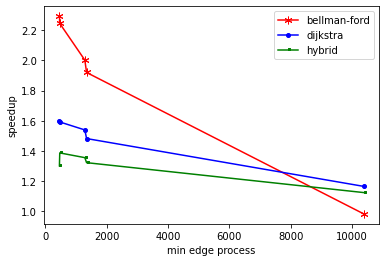

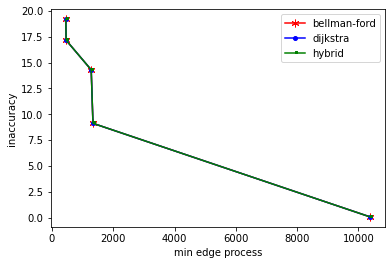

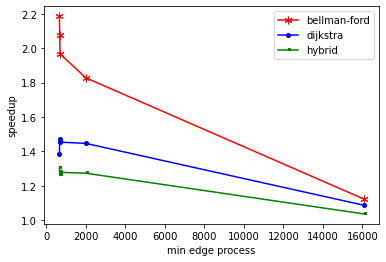

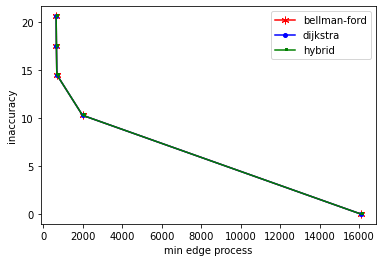

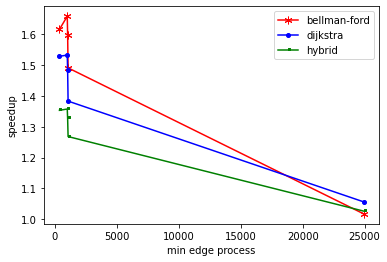

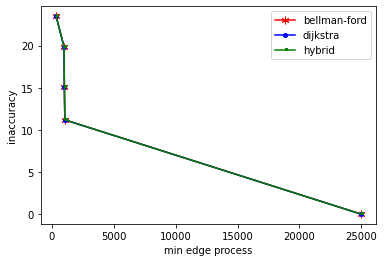

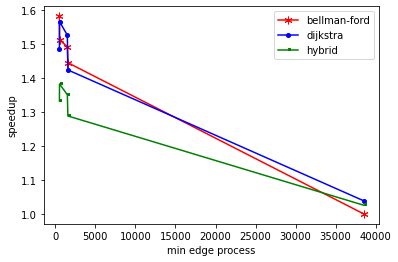

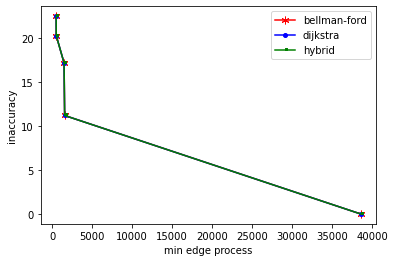

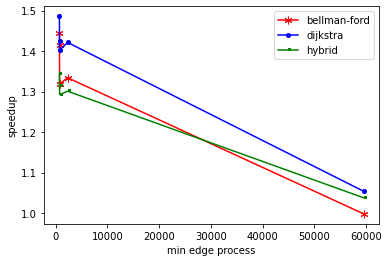

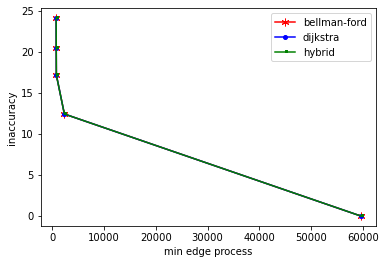

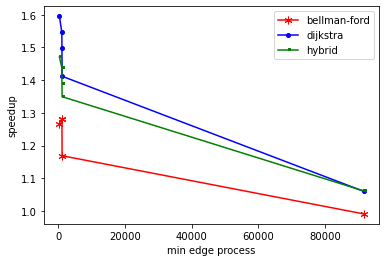

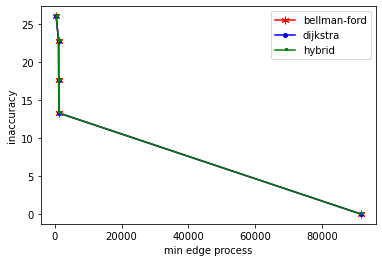

In [214]:
signals = [0, 1, 0, 0]

approximation_technique = 'maxProcessEdge'

for vertexNum in vn:
    approximationB = df1.loc[(df1[algoB] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), approximation_technique].to_numpy()

    speedupB = df1.loc[(df1[algoB] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'speedup'].to_numpy()

    errorB = df1.loc[(df1[algoB] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'Error'].to_numpy()

    approximationD = df1.loc[(df1[algoD] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), approximation_technique].to_numpy()

    speedupD = df1.loc[(df1[algoD] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'speedup'].to_numpy()

    errorD = df1.loc[(df1[algoD] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'Error'].to_numpy()

    approximationH = df1.loc[(df1[algoH] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), approximation_technique].to_numpy()

    speedupH = df1.loc[(df1[algoH] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'speedup'].to_numpy()

    errorH = df1.loc[(df1[algoH] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'Error'].to_numpy()


    draw_BFDJ(speedupB, approximationB, speedupD, approximationD, speedupH, approximationH, "min edge process", "speedup")
    draw_BFDJ(errorB, approximationB, errorD, approximationD, errorH, approximationH, "min edge process", "inaccuracy")

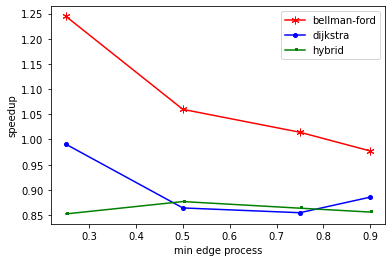

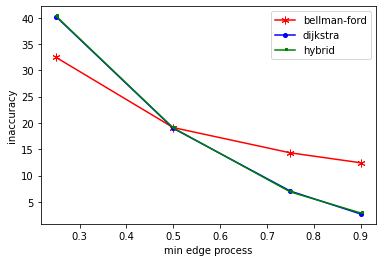

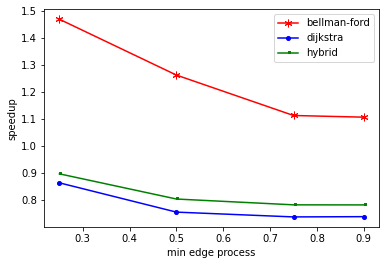

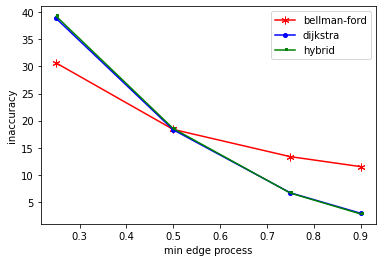

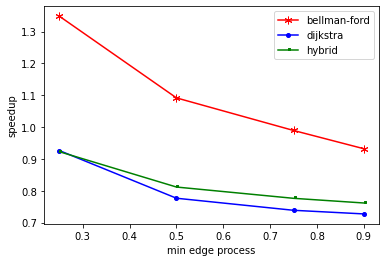

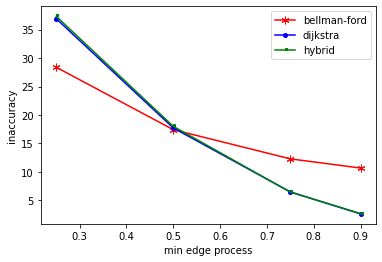

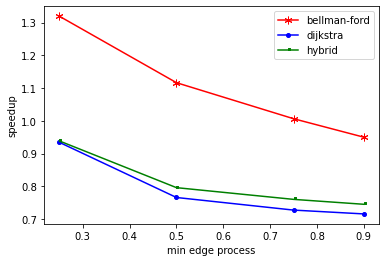

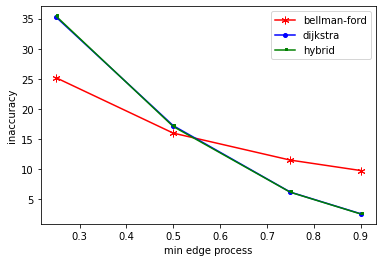

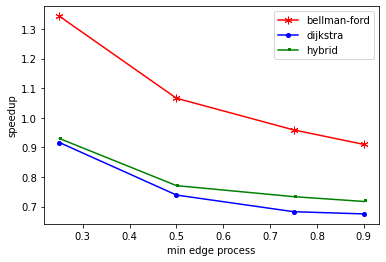

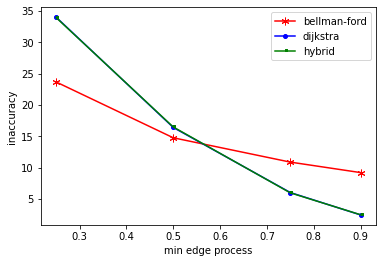

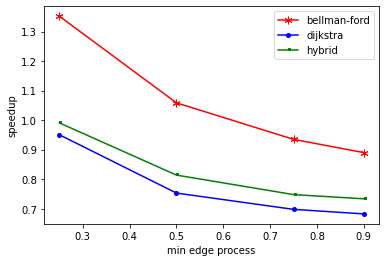

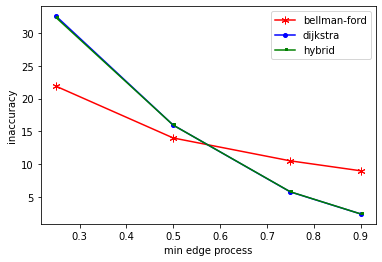

In [215]:
signals = [0, 0, 1, 0]

approximation_technique = 'percentage'

for vertexNum in vn:
    approximationB = df1.loc[(df1[algoB] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), approximation_technique].to_numpy()

    speedupB = df1.loc[(df1[algoB] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'speedup'].to_numpy()

    errorB = df1.loc[(df1[algoB] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'Error'].to_numpy()

    approximationD = df1.loc[(df1[algoD] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), approximation_technique].to_numpy()

    speedupD = df1.loc[(df1[algoD] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'speedup'].to_numpy()

    errorD = df1.loc[(df1[algoD] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'Error'].to_numpy()

    approximationH = df1.loc[(df1[algoH] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), approximation_technique].to_numpy()

    speedupH = df1.loc[(df1[algoH] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'speedup'].to_numpy()

    errorH = df1.loc[(df1[algoH] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'Error'].to_numpy()


    draw_BFDJ(speedupB, approximationB, speedupD, approximationD, speedupH, approximationH, "min edge process", "speedup")
    draw_BFDJ(errorB, approximationB, errorD, approximationD, errorH, approximationH, "min edge process", "inaccuracy")

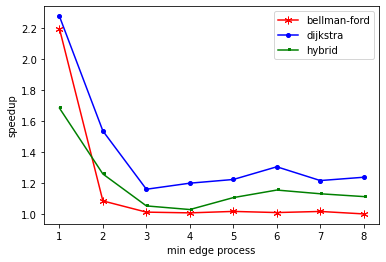

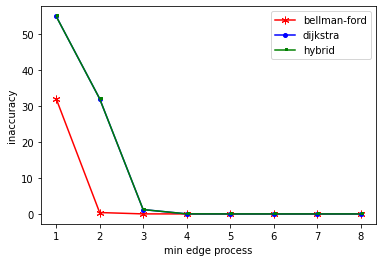

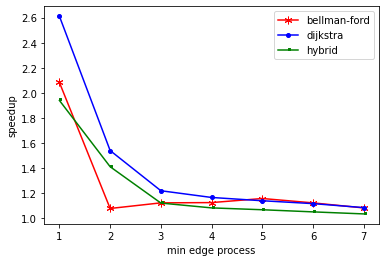

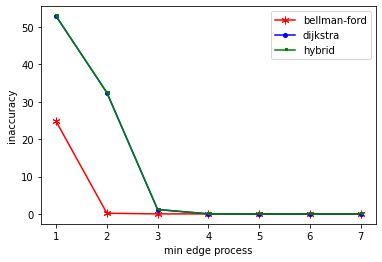

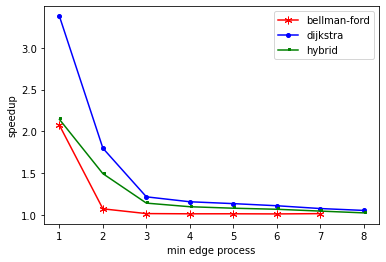

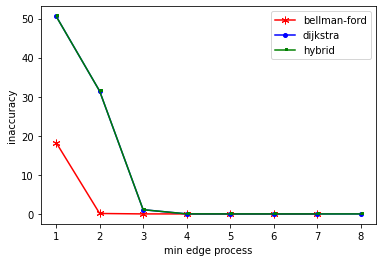

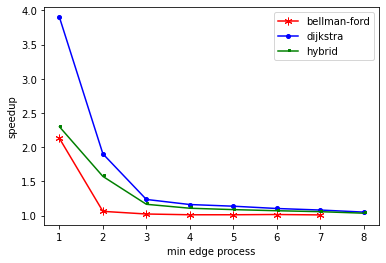

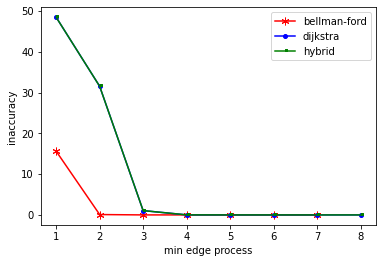

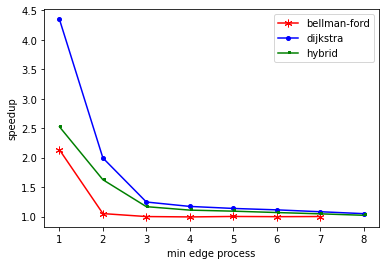

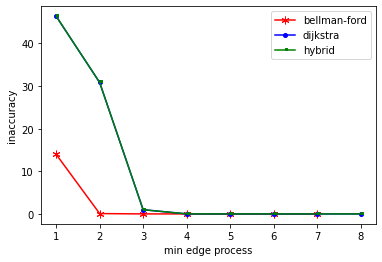

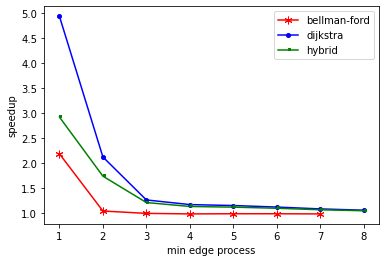

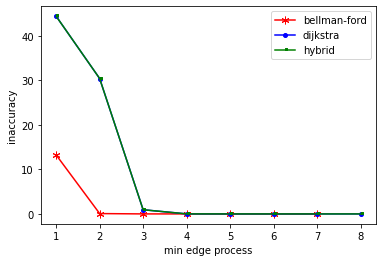

In [216]:
signals = [0, 0, 0, 1]

approximation_technique = 'iterationNum'

for vertexNum in vn:
    approximationB = df1.loc[(df1[algoB] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), approximation_technique].to_numpy()

    speedupB = df1.loc[(df1[algoB] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'speedup'].to_numpy()

    errorB = df1.loc[(df1[algoB] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'Error'].to_numpy()

    approximationD = df1.loc[(df1[algoD] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), approximation_technique].to_numpy()

    speedupD = df1.loc[(df1[algoD] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'speedup'].to_numpy()

    errorD = df1.loc[(df1[algoD] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'Error'].to_numpy()

    approximationH = df1.loc[(df1[algoH] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), approximation_technique].to_numpy()

    speedupH = df1.loc[(df1[algoH] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'speedup'].to_numpy()

    errorH = df1.loc[(df1[algoH] == 1) & (df1['vertexNum'] == vertexNum) &
           (df1['sMinEdgetoProcess'] == signals[0]) & (df1['sMaxEdgetoProcess'] == signals[1]) & 
           (df1['sPartialGraphProcess'] == signals[2]) & (df1['sReduceExecution'] == signals[3]), 'Error'].to_numpy()


    draw_BFDJ(speedupB, approximationB, speedupD, approximationD, speedupH, approximationH, "min edge process", "speedup")
    draw_BFDJ(errorB, approximationB, errorD, approximationD, errorH, approximationH, "min edge process", "inaccuracy")